In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import talib

def N_MACD(df, column='close', short_ma_length=9, long_ma_length=21, normalize_length=50, trigger_length=9):
    # 欄位自動判斷
    col_name = column if column in df.columns else column.lower()
    if col_name not in df.columns:
        raise ValueError(f"Column {column} or {column.lower()} not found in DataFrame columns: {df.columns}")
    close = df[col_name].values

    df['sh'] = talib.EMA(close, short_ma_length)
    df['lon'] = talib.EMA(close, long_ma_length)
    df['ratio'] = np.minimum(df['sh'], df['lon']) / np.maximum(df['sh'], df['lon'])
    df['mac'] = np.where(df['sh'] > df['lon'], 2 - df['ratio'], df['ratio']) - 1
    mac = df['mac']
    df['mac_norm'] = (
        (mac - mac.rolling(window=normalize_length, min_periods=1).min())
        / (mac.rolling(window=normalize_length, min_periods=1).max() - mac.rolling(window=normalize_length, min_periods=1).min() + 1e-9)
    ) * 2 - 1
    df['trigger'] = talib.WMA(df['mac_norm'], timeperiod=trigger_length)
    return df

def N_MACD_entry_logic(df):
    df['Signal'] = 0
    df.loc[df['mac_norm'] > df['trigger'], 'Signal'] = 1
    df.loc[df['mac_norm'] <= df['trigger'], 'Signal'] = 0
    df['entry_price'] = np.where(
    (df['Signal'] == 1) & (df['Signal'].shift(1, fill_value=0) == 0),
    df['open'],  # 這裡可改成 close、high、low，看你要用哪個價位進場
    np.nan
)
    # 持倉期間內 entry_price 用 ffill 向下填滿，空倉時為 nan
    df['entry_price'] = df['entry_price'].ffill()
    return df

def MDD(df):
    df['price_chg'] = df['close'].pct_change()
    df['pnl'] = df['Signal'].shift(1) * df['price_chg']
    df['asset_curve'] = (1 + df['pnl']).cumprod()
    df['DD'] = df['asset_curve'] - df['asset_curve'].cummax()
    df['DD_pct'] = df['DD'] / df['asset_curve'].cummax()   # 補上這行！

    # 找到最大回撤的結束時點
    end = df['DD_pct'].idxmin()
    # 找到最大回撤區間的歷史高點時點
    start = df.loc[:end, 'asset_curve'].idxmax()

    # 轉換為 Timestamp
    MDD_end_time = pd.to_datetime(end)
    MDD_start_time = pd.to_datetime(start)
    MDD_days = (MDD_end_time - MDD_start_time).days

    MDD_val = df.loc[end, 'DD_pct']  # 取該點的 MDD 值

    return MDD_val, MDD_start_time, MDD_end_time, MDD_days


def optimise_param_sr(df):
    best_sr = -np.inf
    best_sh_len = None
    best_lon_len = None

    # 這裡存所有 Sharpe ratio
    sh_range = np.arange(20, 48, 2)
    lon_range = np.arange(sh_range[0]+2, 62, 2)
    heatmap = np.full((len(sh_range), len(lon_range)), np.nan)

    for i, sh in enumerate(sh_range):
        for j, lon in enumerate(lon_range):
            if lon <= sh:  # 只允許 long > short
                continue
            Box = N_MACD(df.copy(), column='close', short_ma_length=sh, long_ma_length=lon, normalize_length=50, trigger_length=9)
            signal = N_MACD_entry_logic(Box)['Signal']
            Box['price_chg'] = Box['close'].pct_change()
            Box['pnl'] = signal.shift(1) * Box['price_chg']
            pnl = Box['pnl'].dropna()

            if pnl.std() == 0 or len(pnl) == 0 or abs(signal).sum() < 3:
                sr = np.nan
            else:
                sr = pnl.mean() / pnl.std() * np.sqrt(365*24)
            heatmap[i, j] = sr
            if sr > best_sr:
                best_sr = sr
                best_sh_len = sh
                best_lon_len = lon

    # 畫 heatmap
    plt.figure(figsize=(10,6))
    sns.heatmap(
        heatmap, 
        annot=True, 
        fmt=".2f", 
        xticklabels=lon_range, 
        yticklabels=sh_range, 
        cmap="coolwarm", 
        linewidths=0.5
    )
    plt.xlabel("Long EMA Length")
    plt.ylabel("Short EMA Length")
    plt.title("Sharpe Ratio Heatmap")
    plt.show()

    return best_sh_len, best_lon_len, best_sr


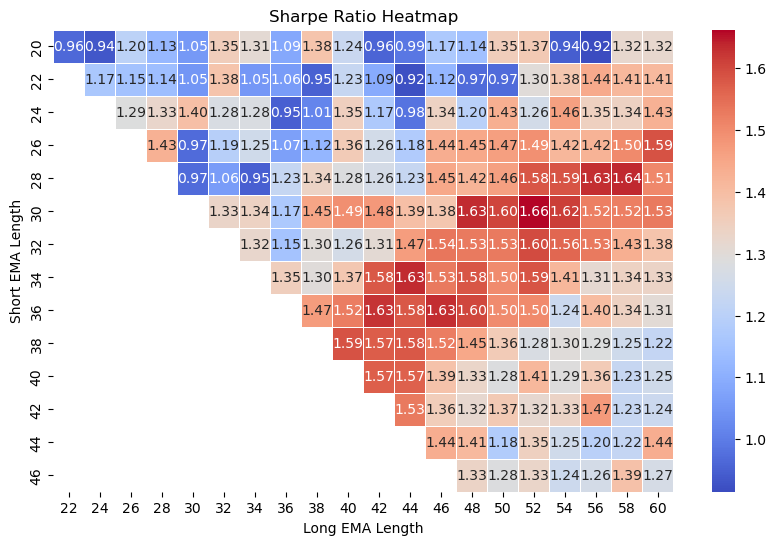

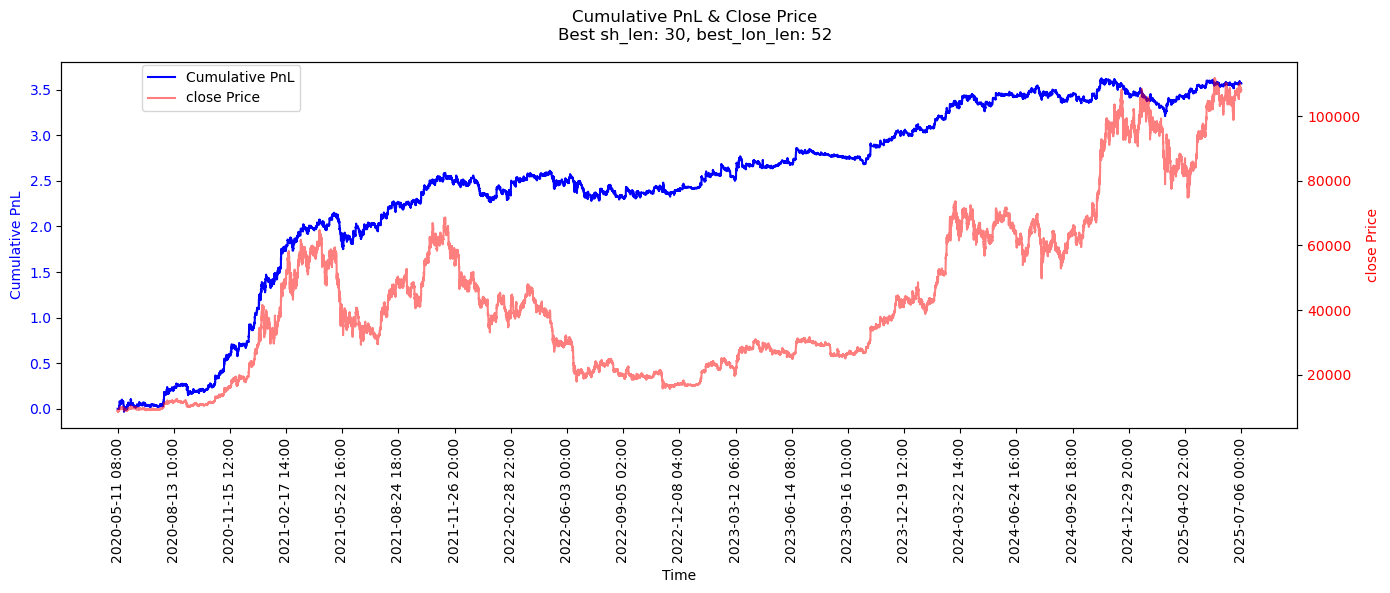

Best Short EMA Length: 30
Best Long EMA Length: 52
Best Sharpe Ratio: 1.6621632890932503
Sharpe Ratio (by trade): 1.66216328909325
Profit Factor: 1.0852339823919788
Maximum Drawdown: -0.41469167899300974
Total ROI: 3.56990401232792
Total Trades: 1705
Fees Paid: 1.8755000000000002
Fees/PnL Ratio: 0.5253642656842737


In [9]:
if __name__ == '__main__':
    # 1. 讀取資料
    df = pd.read_csv("./btc_price_data_1h.csv")
    df.set_index("start_time", inplace=True)

    # 2. 搜尋最佳參數
    best_sh_len, best_lon_len, best_sr = optimise_param_sr(df)   

    # 3. 用最佳參數重算一次指標、進出場
    df = N_MACD(df, column='close', short_ma_length=best_sh_len, long_ma_length=best_lon_len, normalize_length=50, trigger_length=9)
    df = N_MACD_entry_logic(df)

    df['price_chg'] = df['close'].pct_change()
    df['pnl'] = df['Signal'].shift(1) * df['price_chg']
    df['cumu_pnl'] = df['pnl'].cumsum()
    df['DD'] = df['cumu_pnl'] - df['cumu_pnl'].cummax()
    sharpe_ratio = df['pnl'].mean() / df['pnl'].std() * np.sqrt(365*24)
    pnl = df['pnl']
    pf = pnl[pnl>0].sum()/pnl[pnl<0].abs().sum()
    ROI = df['cumu_pnl'].iloc[-1]
    MDD = df['DD'].min()
    total_trades = ((df['Signal'] != df['Signal'].shift(1)) & (df['Signal'] != 0)).sum()
    fees_paid = total_trades * 2 * 0.00055  # 進、出各一次

    # 重新設 index 為整數
    df = df.reset_index()

    # 確認 start_time 是 datetime，這樣顯示才正確
    df['start_time'] = pd.to_datetime(df['start_time'])

    # 決定x軸刻度間隔（預設顯示20個tick，可依資料長度微調）
    n_ticks = 20
    step = max(1, len(df) // n_ticks)
    xticks_pos = df.index[::step]
    xticks_labels = df['start_time'].dt.strftime('%Y-%m-%d %H:%M')[::step]

    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(df['start_time'], df['cumu_pnl'], label='Cumulative PnL', color='blue')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Cumulative PnL", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # 設定 x 軸顯示
    ax1.set_xticks(df['start_time'][::step])
    ax1.set_xticklabels(xticks_labels, rotation=90)  # 90度直列

    # 副軸
    ax2 = ax1.twinx()
    ax2.plot(df['start_time'], df['close'], label='close Price', color='red', alpha=0.5)
    ax2.set_ylabel("close Price", color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    fig.suptitle(f"Cumulative PnL & Close Price\nBest sh_len: {best_sh_len}, best_lon_len: {best_lon_len}")
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
    plt.tight_layout()
    plt.show()

    print("Best Short EMA Length:", best_sh_len)
    print("Best Long EMA Length:", best_lon_len)
    print("Best Sharpe Ratio:", best_sr)
    print("Sharpe Ratio (by trade):", sharpe_ratio)
    print("Profit Factor:", pf)
    print("Maximum Drawdown:", MDD)
    print("Total ROI:", ROI)
    print("Total Trades:", total_trades)
    print("Fees Paid:", fees_paid)
    print("Fees/PnL Ratio:", fees_paid / abs(ROI))

#df.to_csv("./N-MACD_wma.csv", index=False)


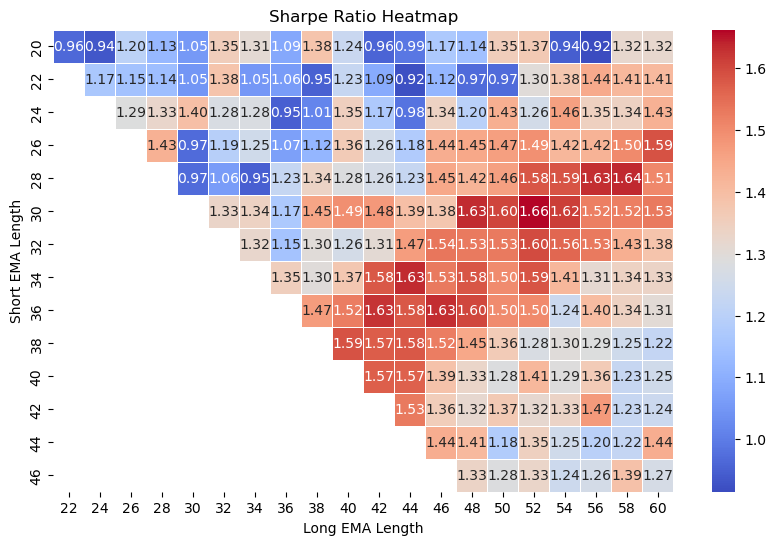

Best sh_len: 30, Best lon_len: 52, Best Sharpe: 1.6622


D:\Personal\Temp\ipykernel_16540\3691276419.py:63: UserWarning: Glyph 35079 (\N{CJK UNIFIED IDEOGRAPH-8907}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\Personal\Temp\ipykernel_16540\3691276419.py:63: UserWarning: Glyph 21033 (\N{CJK UNIFIED IDEOGRAPH-5229}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\Personal\Temp\ipykernel_16540\3691276419.py:63: UserWarning: Glyph 26412 (\N{CJK UNIFIED IDEOGRAPH-672C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\Personal\Temp\ipykernel_16540\3691276419.py:63: UserWarning: Glyph 37329 (\N{CJK UNIFIED IDEOGRAPH-91D1}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\user\miniconda3\envs\cybotrade\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35079 (\N{CJK UNIFIED IDEOGRAPH-8907}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\user\miniconda3\envs\cybotrade\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21033 (\N{C

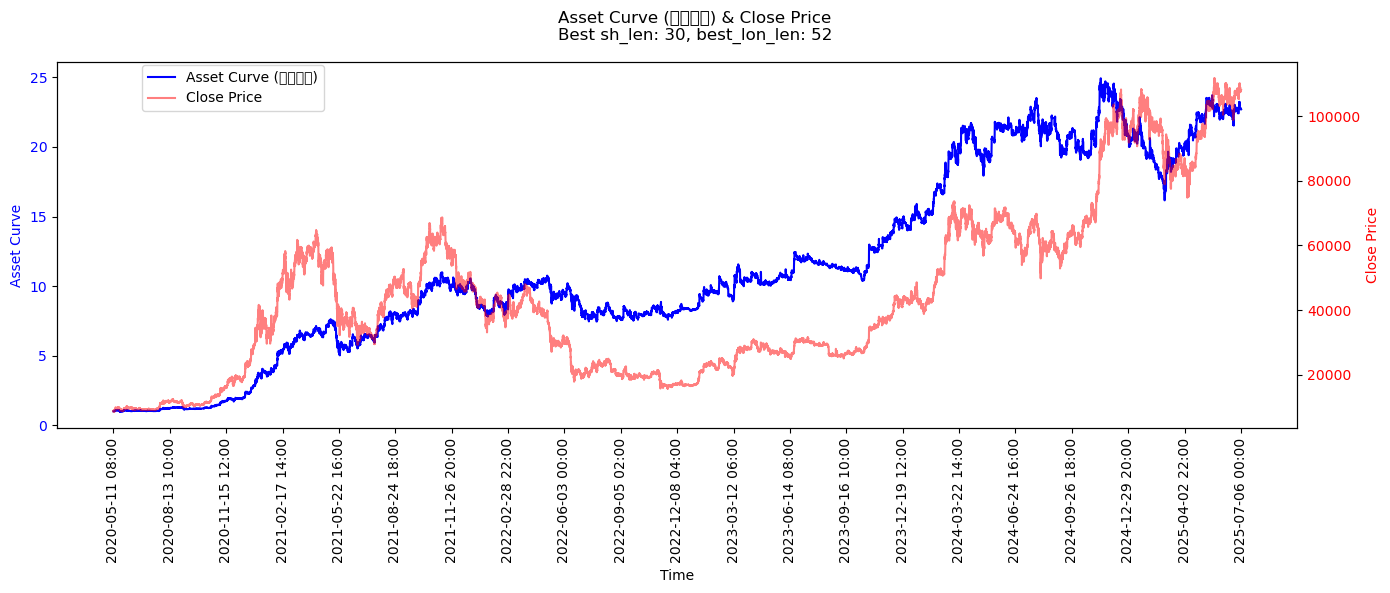

Best Short EMA Length: 30
Best Long EMA Length: 52
Sharpe Ratio: 1.6621632890932503
Profit Factor: 1.0852339823919788
Maximum Drawdown (複利%): -35.17451662499536 %
Final Asset Value (本金1元最後變多少): 22.713020015801412
Total ROI (複利): 21.713020015801412
Total Trades: 1705
Fees Paid: 1.8755000000000002
Fees/PnL Ratio: 0.0863767453184829
Maximum Drawdown: -35.17%
From 2024-11-14 02:00:00 to 2025-02-28 09:00:00 (106 days)


In [ ]:
# === 回測主程式 ===
if __name__ == '__main__':
    # 1. 讀取資料
    df = pd.read_csv("./btc_price_data_1h.csv")
    df.set_index("start_time", inplace=True)
    
    # 2. 搜尋最佳參數
    best_sh_len, best_lon_len, best_sr = optimise_param_sr(df)
    
    # 3. 用最佳參數重算一次指標與進出場訊號
    df = N_MACD(df, column='close', short_ma_length=best_sh_len, long_ma_length=best_lon_len, normalize_length=50, trigger_length=9)
    df = N_MACD_entry_logic(df)
    
    # 4. 計算每根的報酬率與資產曲線（複利）
    df['price_chg'] = df['close'].pct_change()
    df['pnl'] = df['Signal'].shift(1) * df['price_chg']
    df['asset_curve'] = (1 + df['pnl']).cumprod()
    
    # 5. 手續費計算（只在開/平倉點收費）
    trade_signals = (df['Signal'] != df['Signal'].shift(1)) & (df['Signal'] != 0)
    total_trades = trade_signals.sum()
    trading_fee = 0.00055 # 假設單邊千分之0.55
    fees_paid = total_trades * 2 * trading_fee # 開/平各一次
    
    # 6. 資產曲線績效指標
    returns = df['pnl'].dropna()
    sharpe = returns.mean() / returns.std() * np.sqrt(365*24) # 以小時K為例
    profit_factor = returns[returns > 0].sum() / abs(returns[returns < 0].sum())
    
    df['DD'] = df['asset_curve'] - df['asset_curve'].cummax()
    df['DD_pct'] = df['DD'] / df['asset_curve'].cummax()
    MDD_val, MDD_start_time, MDD_end_time, MDD_days = MDD(df)
    final_value = df['asset_curve'].iloc[-1]
    ROI = final_value - 1

    fees_pnl_ratio = fees_paid / abs(ROI) if ROI != 0 else float('inf')
    
    # 7. 資金曲線繪圖（含複利資產線）
    df = df.reset_index()
    df['start_time'] = pd.to_datetime(df['start_time'])
    n_ticks = 20
    step = max(1, len(df) // n_ticks)
    xticks_pos = df.index[::step]
    xticks_labels = df['start_time'].dt.strftime('%Y-%m-%d %H:%M')[::step]
    
    import matplotlib.pyplot as plt
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(df['start_time'], df['asset_curve'], label='Asset Curve (複利本金)', color='blue')
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Asset Curve", color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xticks(df['start_time'][::step])
    ax1.set_xticklabels(xticks_labels, rotation=90)
    
    ax2 = ax1.twinx()
    ax2.plot(df['start_time'], df['close'], label='Close Price', color='red', alpha=0.5)
    ax2.set_ylabel("Close Price", color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    fig.suptitle(f"Asset Curve (複利本金) & Close Price\nBest sh_len: {best_sh_len}, best_lon_len: {best_lon_len}")
    fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
    plt.tight_layout()
    plt.show()
    
    # 8. 輸出績效
    print("Best Short EMA Length:", best_sh_len)
    print("Best Long EMA Length:", best_lon_len)
    print("Sharpe Ratio:", sharpe)
    print("Profit Factor:", profit_factor)
    print("Maximum Drawdown (複利%):", MDD_val * 100, "%")
    print("Final Asset Value (本金1元最後變多少):", final_value)
    print("Total ROI (複利):", ROI)
    print("Total Trades:", total_trades)
    print("Fees Paid:", fees_paid)
    print("Fees/PnL Ratio:", fees_pnl_ratio)
    print(f"Maximum Drawdown: {MDD_val*100:.2f}%")
    print(f"From {MDD_start_time} to {MDD_end_time} ({MDD_days} days)")


df.to_csv("./N-MACD_wma_GPT.csv", index=False)
